<a href="https://colab.research.google.com/github/IshantWadhwa4/Machine_Learning/blob/master/Dimensionality%20Reduction/LDA_Dem_Red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDA 

In [0]:
# notes
# Diff b/w PCA and LDA is LDA do care about the class(target variable), in pca we did not consider any type of class(Target variable).LDA is a supervise learning.
# LDA and PCA work in same way.
# LDA help in selecting features, which are helping in sepreating class. 

#### Solve a problem using LDA and see how it change the result.

## Table of Contents

1.   [Get Data](#Section1)
2.   [Basic EDA](#Section2)
3.   [Pre-Modeling](#Section3)
4.   [Modeling](#Section4)
5.   [Post Modeling](#Section5)
6.   [ML Interpretation | Explaninable AI](#Section6)
7.   [Model Deployment | MLOps](#Section7)
8.   [Create Dashbord](#Section8) 

## Get Data

In [0]:
import pandas as pd
import numpy as np

In [0]:
url = 'https://raw.githubusercontent.com/insaid2018/Term-4/master/Data/Assignment/Attrition_LDA.csv'
data = pd.read_csv(filepath_or_buffer=url)

In [4]:
data.shape

(1470, 35)

In [0]:
data.info()
# no null value, 35 columns and 1470 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [0]:
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [0]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [19]:
data['StandardHours'].unique()

array([80])

In [0]:
# Important insight
#  Education is a odinal data so put it as its or change it to binary encoding.
#  EmployeeCount has all value 1 so remove this column 
#  EmployeeNumber is also removed
#  Think about job involvment 
# Over18 remove has only one value

# data is ood just remove some columns ['Over18','EmployeeCount','EmployeeNumber','StandardHours']

## Basic EDA

In [0]:
!pip install pandas_profiling==2.5.0

In [0]:
import pandas_profiling
report = pandas_profiling.ProfileReport(data)
#covert profile report as html file
report.to_file("EDA.html")

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
def get_numeric_data_columns(df):
  '''
      return list of all numeric data columns name
  '''
  return list(df._get_numeric_data().columns)

def get_catagorical_data_columns(df):
  '''
      return list of all catagoric data columns name
  '''
  return list(set(df.columns) - set(df._get_numeric_data().columns))

In [0]:
def draw_countPlot_grid(df):
  import math
  fig=plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
  list_columns = get_catagorical_data_columns(df)
  n_rows = math.ceil(len(list_columns)/3)
  n_cols = 3
  for i, var_name in enumerate(list_columns):
    if len(df[var_name].unique()) < 10:
      ax=fig.add_subplot(n_rows,n_cols,i+1)
      sns.countplot(x = var_name, data=df)
      ax.set_title(var_name+" Distribution")
  fig.tight_layout()  # Improves appearance a bit.
  plt.show()

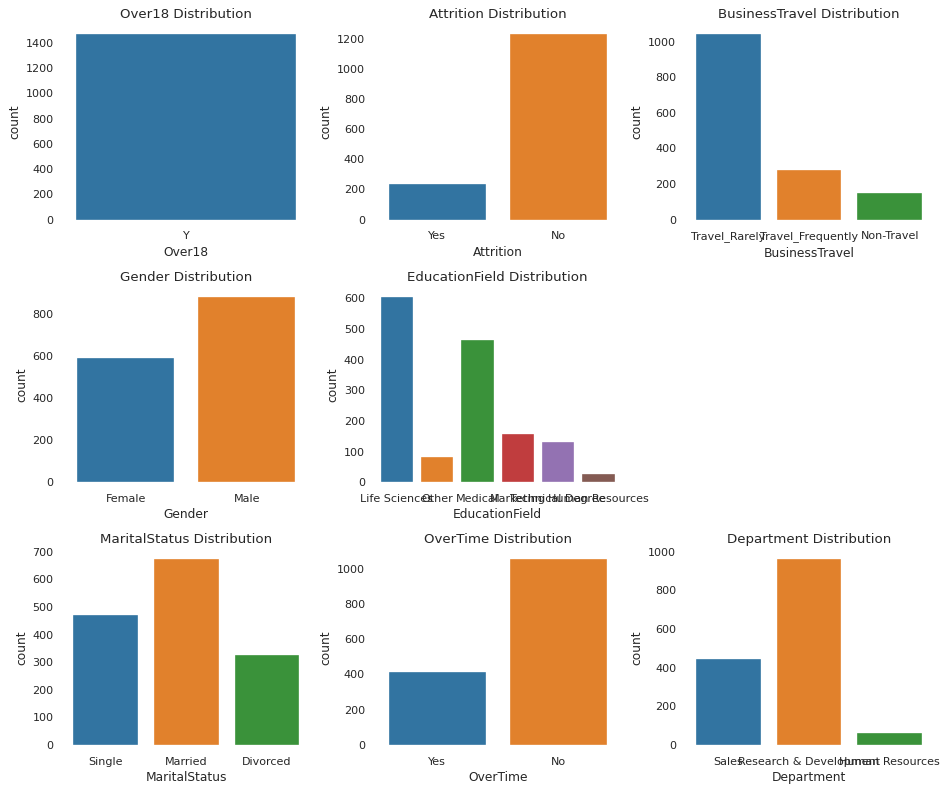

In [0]:
draw_countPlot_grid(data)
# Info: Attrition has im-balance data has very less number of yes so need to do Smote(upsampling)

In [0]:
from random import randint
def draw_distributionPlot_grid(df):
  import math
  fig=plt.figure(num=None, figsize=(12, 50), dpi=80, facecolor='w', edgecolor='k')
  list_columns = get_numeric_data_columns(df)
  n_rows = math.ceil(len(list_columns)/3)
  n_cols = 3
  colors = []
  for i in range(n_rows*n_cols):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
  for i, var_name in enumerate(list_columns):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    sns.distplot(df[var_name],hist=True,axlabel=var_name,color=colors[i])
    ax.set_title(var_name+" Distribution")
  fig.tight_layout()  # Improves appearance a bit.
  plt.show()

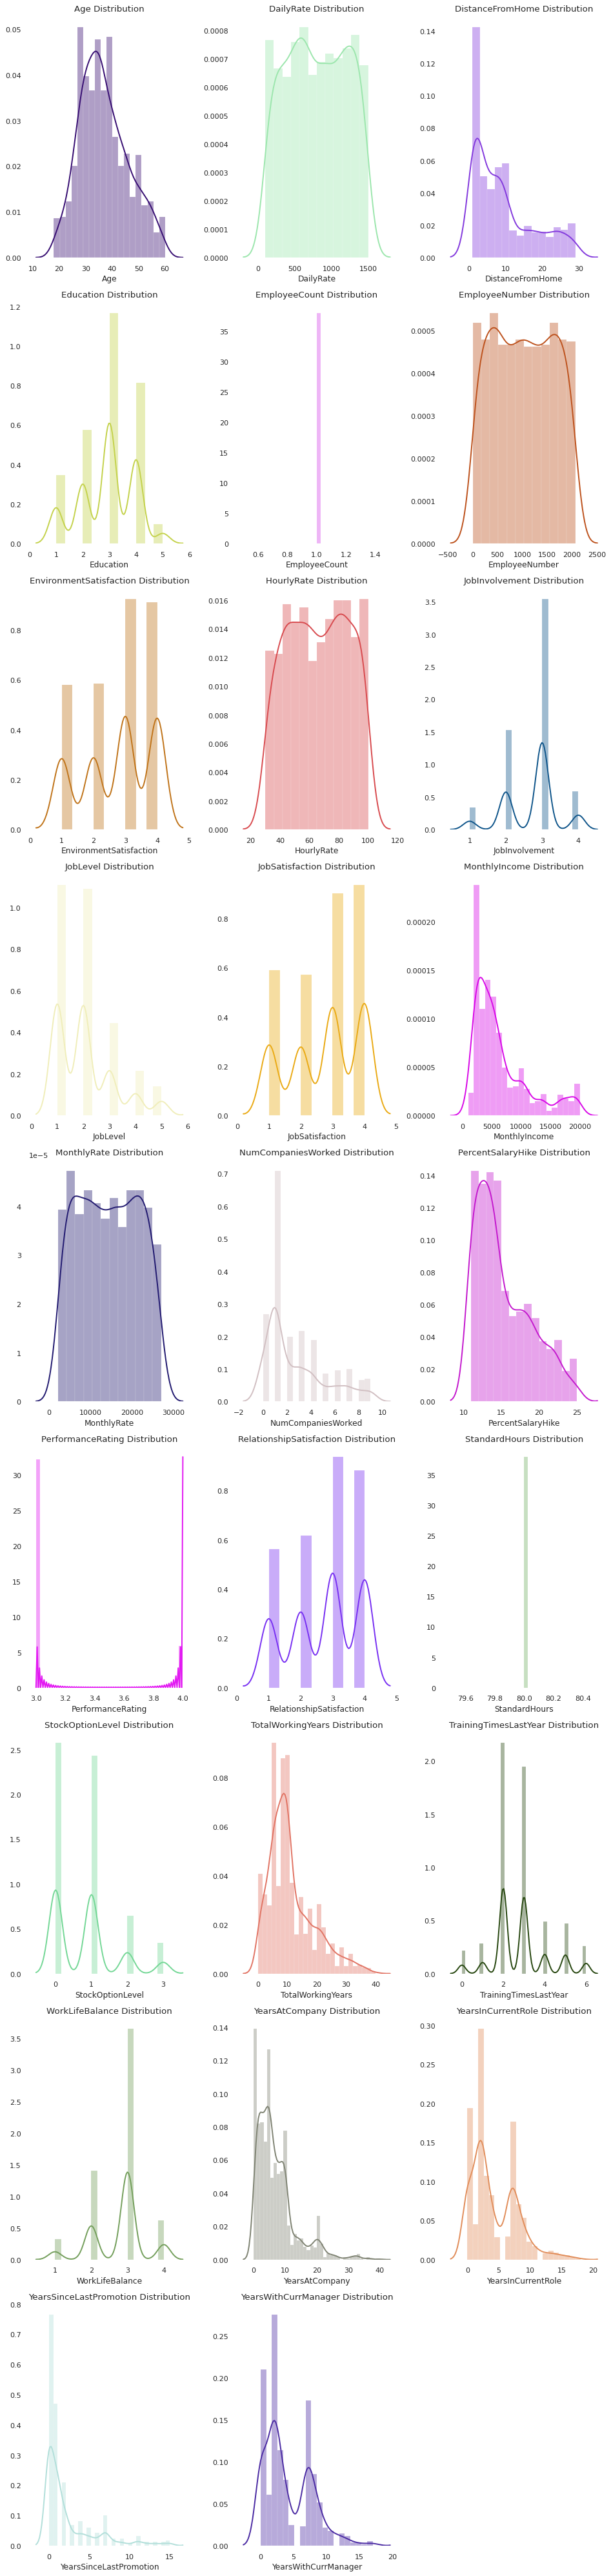

In [18]:
draw_distributionPlot_grid(data)

In [0]:
# create Heatmap for highly co-related(given threshold) columns
# seaborn pandas and numpy

def create_seaborn_heatmap_highcorelated(df,posThreshold,negThreshold):
  '''
      create Heatmap for highly co-related(given threshold) columns

      Input: dataframe, positive threshold, negitive threshold
      Plot: Heatmap
  '''
  df_corr = df.corr()
  tempdf = df_corr[(df_corr > posThreshold) | (df_corr < -negThreshold)]
  tempdf.replace(to_replace=1,value=np.nan,inplace=True)
  tempdf.dropna(axis=1,how='all',inplace=True)
  tempdf.dropna(axis=0,how='all',inplace=True)
  sns.heatmap(tempdf,annot=True, cmap="Blues")


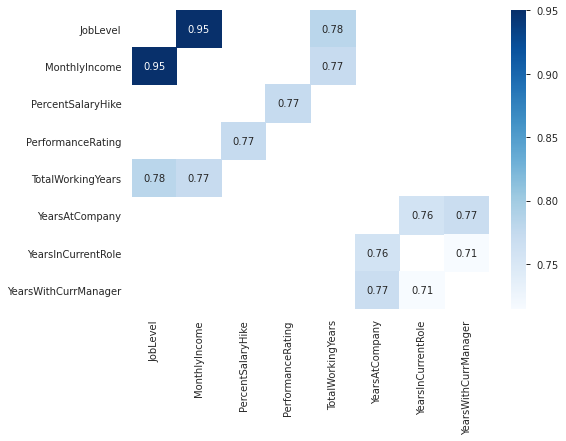

In [43]:
create_seaborn_heatmap_highcorelated(data,0.7,0.7)
# monthlyIncome and joblevel are highly corelated

## Pre-Modeling

In [0]:
# Tasks 
# 1. Need to remove ['Over18','EmployeeCount','EmployeeNumber','StandardHours'] columns
# 2. Encoding is required
# 3. Scaling of data is must
# 4. Need to see about im-balance data
# 5. Apply LDA for dimension reduction

In [0]:
data.drop(['Over18','EmployeeCount','EmployeeNumber','StandardHours'],inplace=True,axis=1)

In [0]:
target = data['Attrition']
data.drop('Attrition',inplace = True,axis=1)

In [0]:
def do_onehot_Encoding(df,list_columns):
  return pd.get_dummies(data = df, columns = list_columns)

In [0]:
# do dummy encoding all are nominal data more than 2 unique items 
# Important point befor doing label encoding check the column in  odinal (label encoding) if Nominal (One hot encoding)

data = do_onehot_Encoding(data,get_catagorical_data_columns(data))

In [0]:
data['Attrition'] = target

In [0]:
from sklearn.preprocessing import LabelEncoder
def do_label_Encoding(df,column_list):
  encode = LabelEncoder()
  for col in column_list:
    if isinstance(df[col].dtype, object):
      df[col] = encode.fit_transform(df[col])
  return df

In [0]:
data = do_label_Encoding(data,['Attrition'])

In [0]:
# standered scaling

In [0]:
from sklearn.preprocessing import StandardScaler
def do_standardScale(X):
  sc = StandardScaler()
  sc.fit(X)
  x_sc = sc.transform(X)
  x_sc_df = pd.DataFrame(x_sc,columns=X.columns)
  return x_sc_df

In [0]:
# data split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data.drop('Attrition',axis=1),data['Attrition'],test_size=0.3,random_state=32)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
DTR = {'criterion' : ['gini', 'entropy'], 'splitter' : ['random', 'best'], 'max_depth':[2,5,10], 'min_samples_leaf':[2,5,10]}

In [0]:
gs = GridSearchCV(DecisionTreeClassifier(), DTR, cv=3, n_jobs=-1, verbose=True, refit=True,scoring='f1', return_train_score=True)

In [23]:
result = gs.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.0s finished


In [0]:
y_predict = result.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix,precision_score


In [44]:
precision_score(y_predict,y_test)

1.0

In [0]:
result.cv_results_['params']


In [39]:
list(result.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_criterion',
 'param_max_depth',
 'param_min_samples_leaf',
 'param_splitter',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'mean_train_score',
 'std_train_score']

In [36]:
result.cv_results_

{'mean_fit_time': array([0.00544707, 0.00505034, 0.00432158, 0.00621303, 0.00438452,
        0.00772103, 0.00524092, 0.00607618, 0.00412424, 0.0049533 ,
        0.00415365, 0.00476845, 0.00413752, 0.00509834, 0.00608587,
        0.00472275, 0.00419744, 0.00470082, 0.00597326, 0.00692916,
        0.00404135, 0.00720501, 0.00414856, 0.00607038, 0.00412226,
        0.00525339, 0.00404509, 0.00520277, 0.00402864, 0.00504756,
        0.00417765, 0.00508006, 0.00389504, 0.00502443, 0.00402236,
        0.00494885]),
 'mean_score_time': array([0.00310683, 0.00280237, 0.00301496, 0.00297872, 0.00287724,
        0.00275509, 0.00277408, 0.00277837, 0.00282741, 0.00274404,
        0.00280658, 0.0036401 , 0.00270486, 0.00455109, 0.0028712 ,
        0.0027101 , 0.00275564, 0.00268571, 0.00269222, 0.00278751,
        0.00270089, 0.00443737, 0.0033377 , 0.00284799, 0.00373212,
        0.00279633, 0.0026679 , 0.00269715, 0.00265201, 0.00275405,
        0.0028042 , 0.00269787, 0.00276248, 0.00268801, 0.

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [46]:
lda = LDA( n_components = 2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(53, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [67]:
y_train

914     0
1291    1
897     0
1070    0
628     0
       ..
1427    0
88      0
892     1
1334    0
727     0
Name: Attrition, Length: 1029, dtype: int64

In [50]:
from sklearn.linear_model import LogisticRegression
import time
classifier = LogisticRegression(penalty='l2', solver='sag', C=1)
start_time = time.time()
fit2 = classifier.fit(X_train, y_train)
end_time = time.time()
time3 = end_time-start_time
print(time3)

0.009136438369750977


In [0]:
y_pred = fit2.predict(X_test)

In [52]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,

In [0]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

In [55]:
cm


array([[358,  10],
       [ 48,  25]])

In [56]:
result = gs.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.6s finished


In [0]:
y_predict = result.predict(X_test)

In [58]:
from sklearn.metrics import confusion_matrix,precision_score
precision_score(y_predict,y_test)

0.3013698630136986

In [60]:
confusion_matrix(y_test, y_predict)

array([[358,  10],
       [ 51,  22]])